# IQM Optimization Level Comparison

Compare transpilation with optimization levels 0, 1, 2, and 3 on IQM backend.

## Setup

In [ ]:
"""
Setup and Configuration
Import required libraries and initialize IQM backend
"""
from iqm.qiskit_iqm import IQMFakeAdonis
from qiskit import QuantumCircuit, transpile
import matplotlib.pyplot as plt
import numpy as np

# Configuration constants
NUM_QUBITS = 5
ENTANGLEMENT_LAYERS = 2
ROTATION_PARAMS = {'rz': 0.5, 'ry': 0.3}

# Initialize IQM backend
backend = IQMFakeAdonis()
print(f"Backend: {backend.name}")
print(f"Number of Qubits: {backend.num_qubits}")
print(f"Available Operations: {backend.operation_names}")

# Create a complex test circuit (Grover-inspired algorithm)
grover = QuantumCircuit(NUM_QUBITS, NUM_QUBITS)

# Step 1: Initial superposition
grover.h(range(NUM_QUBITS))

# Step 2: Oracle - multiple layers of entanglement
for layer in range(ENTANGLEMENT_LAYERS):
    grover.cz(0, 1)
    grover.cz(1, 2)
    grover.cz(2, 3)
    grover.cz(3, 4)
    grover.cz(0, 4)
    grover.h(range(NUM_QUBITS))

# Step 3: Diffusion operator with multi-controlled gates
grover.x(range(NUM_QUBITS))
grover.h(4)
grover.mcx([0, 1, 2, 3], 4)  # Multi-controlled X gate
grover.h(4)
grover.x(range(NUM_QUBITS))
grover.h(range(NUM_QUBITS))

# Step 4: Additional rotation layer for complexity
for i in range(NUM_QUBITS):
    grover.rz(ROTATION_PARAMS['rz'], i)
    grover.ry(ROTATION_PARAMS['ry'], i)

# Step 5: Final entanglement ring
for i in range(NUM_QUBITS - 1):
    grover.cx(i, i + 1)
grover.cx(NUM_QUBITS - 1, 0)  # Close the ring

grover.h(range(NUM_QUBITS))
grover.measure(range(NUM_QUBITS), range(NUM_QUBITS))

print(f"\nOriginal Circuit Statistics:")
print(f"  Depth: {grover.depth()}")
print(f"  Gates: {grover.size()}")
print(f"  Qubits: {grover.num_qubits}")
print(f"  Operations: {dict(grover.count_ops())}")

## Transpile and Execute

In [ ]:
"""
Transpile and execute circuit with different optimization levels
Compare how each level optimizes the circuit for IQM backend
"""
OPTIMIZATION_LEVELS = [0, 1, 2, 3]
SHOTS = 4000  # Matching IBM experiment for fair comparison

transpiled_circuits = {}
results_dict = {}

print("=" * 80)
print("TRANSPILATION AND EXECUTION")
print("=" * 80)

for level in OPTIMIZATION_LEVELS:
    print(f"\nOptimization Level {level}:")
    print("-" * 50)
    
    try:
        # Transpile circuit for backend
        transpiled_circuits[level] = transpile(
            grover,
            backend=backend,
            optimization_level=level,
            seed_transpiler=42  # For reproducibility
        )
        
        circuit = transpiled_circuits[level]
        
        # Calculate improvement metrics
        depth_reduction = (1 - circuit.depth() / grover.depth()) * 100
        gate_reduction = (1 - circuit.size() / grover.size()) * 100
        
        print(f"  Depth: {circuit.depth()} ({depth_reduction:+.1f}%)")
        print(f"  Gates: {circuit.size()} ({gate_reduction:+.1f}%)")
        
        # Execute circuit
        job = backend.run(circuit, shots=SHOTS)
        result = job.result()
        results_dict[level] = result.get_counts()
        
        print(f"  Status: ✓ Executed successfully")
        
    except Exception as e:
        print(f"  Status: ✗ Error - {str(e)[:70]}")
        results_dict[level] = {}

print("\n" + "=" * 80)
print("Transpilation completed for all optimization levels!")
print("=" * 80)

## Circuit Comparison

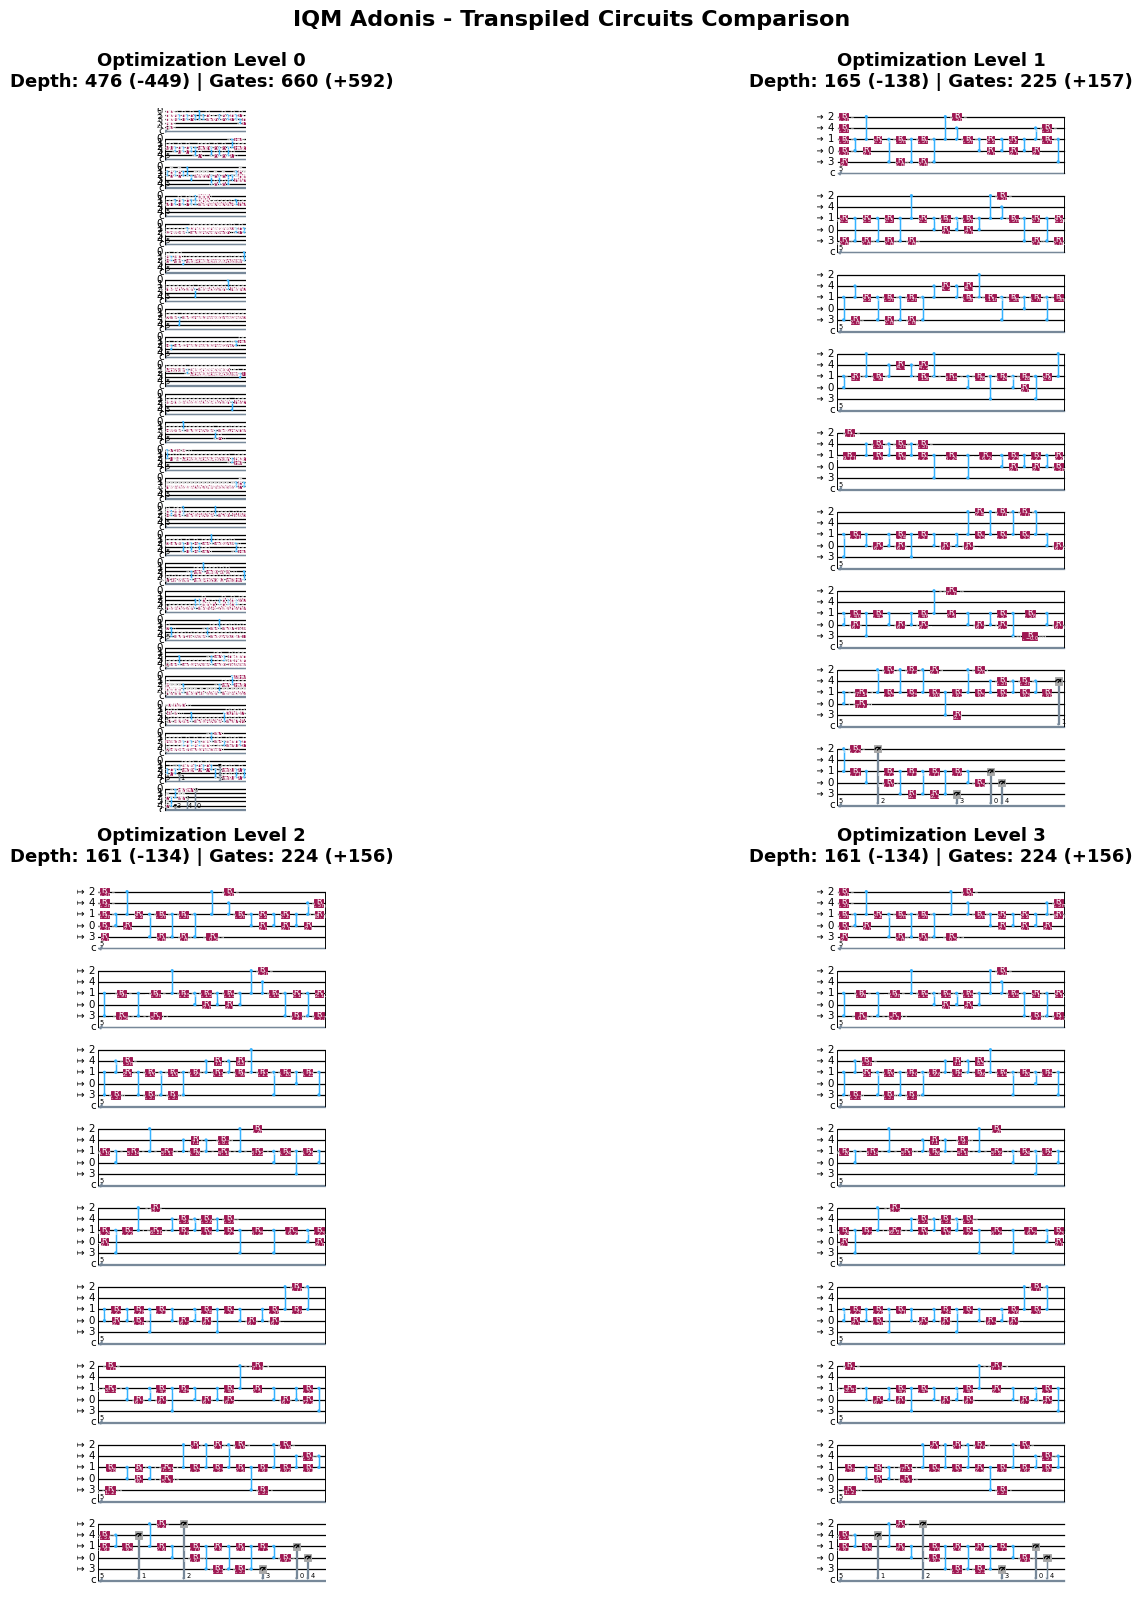

In [38]:
"""
Visualize transpiled circuits - simplified view
"""
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for idx, level in enumerate(OPTIMIZATION_LEVELS):
    if level in transpiled_circuits:
        circuit = transpiled_circuits[level]
        
        # Use text drawing for clearer view of small circuits
        circuit.draw('mpl', ax=axes[idx], style='iqp', fold=20)
        
        # Calculate metrics
        depth_reduction = grover.depth() - circuit.depth()
        gate_reduction = circuit.size() - grover.size()
        
        title = (f'Optimization Level {level}\n'
                f'Depth: {circuit.depth()} ({depth_reduction:+d}) | '
                f'Gates: {circuit.size()} ({gate_reduction:+d})')
        axes[idx].set_title(title, fontsize=13, fontweight='bold', pad=15)
    else:
        axes[idx].text(0.5, 0.5, 'Circuit not available', 
                      ha='center', va='center', transform=axes[idx].transAxes,
                      fontsize=12)
        axes[idx].set_title(f'Level {level}', fontweight='bold')
        axes[idx].axis('off')

plt.suptitle('IQM Adonis - Transpiled Circuits Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Statistics and Results

In [39]:
"""
Display detailed statistics and execution results
"""
print("=" * 80)
print("CIRCUIT STATISTICS COMPARISON")
print("=" * 80)
print(f"\nOriginal Circuit:")
print(f"  Depth: {grover.depth()}")
print(f"  Gates: {grover.size()}")
print(f"  Qubits: {grover.num_qubits}")
print(f"  Operations: {dict(grover.count_ops())}")

print(f"\nTranspiled Circuits:")
print("-" * 80)

for level in OPTIMIZATION_LEVELS:
    if level in transpiled_circuits:
        circuit = transpiled_circuits[level]
        depth_change = circuit.depth() - grover.depth()
        gate_change = circuit.size() - grover.size()
        
        print(f"\nLevel {level}:")
        print(f"  Depth: {circuit.depth():3d} ({depth_change:+3d} from original)")
        print(f"  Gates: {circuit.size():3d} ({gate_change:+3d} from original)")
        print(f"  Operations: {dict(circuit.count_ops())}")

print("\n" + "=" * 80)
print("EXECUTION RESULTS (Top 5 States)")
print("=" * 80)

for level in OPTIMIZATION_LEVELS:
    if level in results_dict and results_dict[level]:
        counts = results_dict[level]
        top_5 = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5])
        
        print(f"\nOptimization Level {level}:")
        for state, count in top_5.items():
            probability = (count / SHOTS) * 100
            bar = '█' * int(probability / 2)
            print(f"  |{state}⟩: {count:4d} ({probability:5.2f}%) {bar}")
    else:
        print(f"\nLevel {level}: No results available")

CIRCUIT STATISTICS COMPARISON

Original Circuit:
  Depth: 27
  Gates: 68
  Qubits: 5
  Operations: {'h': 27, 'cz': 10, 'x': 10, 'rz': 5, 'ry': 5, 'cx': 5, 'measure': 5, 'mcx': 1}

Transpiled Circuits:
--------------------------------------------------------------------------------

Level 0:
  Depth: 476 (+449 from original)
  Gates: 660 (+592 from original)
  Operations: {'r': 559, 'cz': 96, 'measure': 5}

Level 1:
  Depth: 165 (+138 from original)
  Gates: 225 (+157 from original)
  Operations: {'r': 133, 'cz': 87, 'measure': 5}

Level 2:
  Depth: 161 (+134 from original)
  Gates: 224 (+156 from original)
  Operations: {'r': 136, 'cz': 83, 'measure': 5}

Level 3:
  Depth: 161 (+134 from original)
  Gates: 224 (+156 from original)
  Operations: {'r': 136, 'cz': 83, 'measure': 5}

EXECUTION RESULTS (Top 5 States)

Optimization Level 0:
  |10000⟩:  144 ( 3.60%) █
  |11100⟩:  140 ( 3.50%) █
  |00000⟩:  139 ( 3.48%) █
  |11110⟩:  138 ( 3.45%) █
  |10100⟩:  135 ( 3.38%) █

Optimization Leve

## Visual Comparison

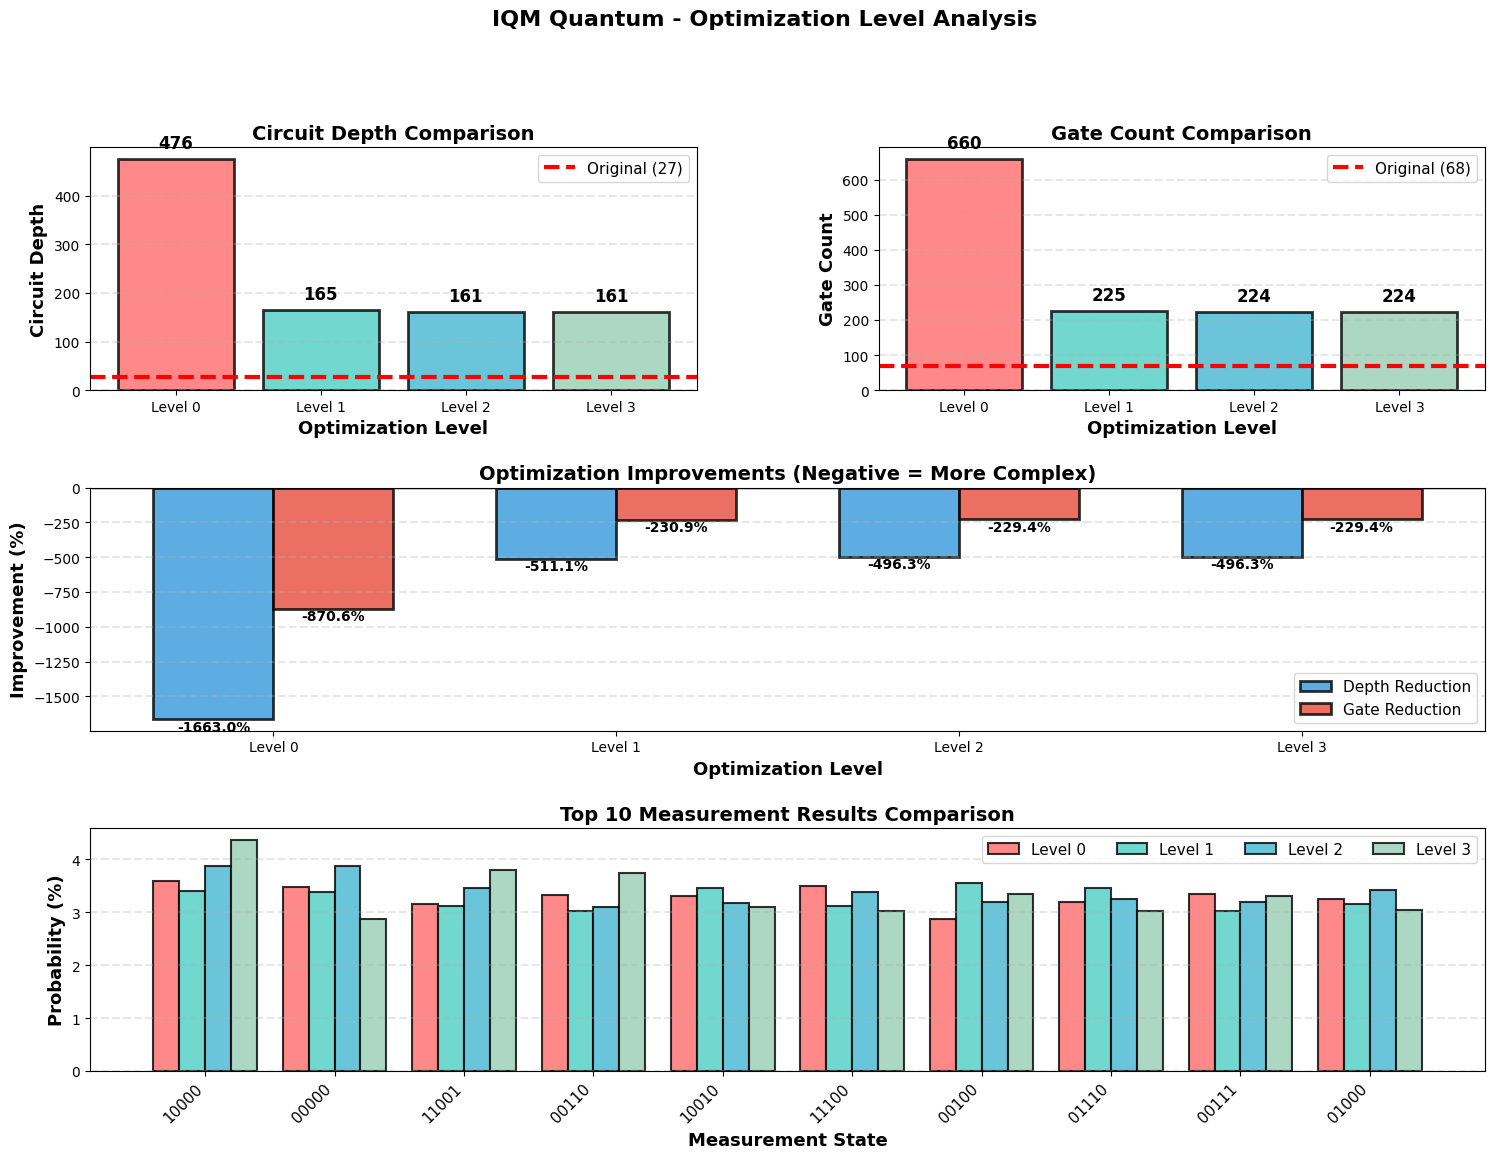


Analysis complete!


In [40]:
"""
Clear visual comparison of optimization effectiveness
"""
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3)

# Color scheme
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# --- SUBPLOT 1: Circuit Depth Comparison ---
ax1 = fig.add_subplot(gs[0, 0])
depths = [transpiled_circuits[level].depth() for level in OPTIMIZATION_LEVELS 
          if level in transpiled_circuits]
labels = [f"Level {l}" for l in OPTIMIZATION_LEVELS if l in transpiled_circuits]

bars1 = ax1.bar(labels, depths, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.axhline(y=grover.depth(), color='red', linestyle='--', label=f'Original ({grover.depth()})', linewidth=3)
ax1.set_ylabel('Circuit Depth', fontsize=13, fontweight='bold')
ax1.set_xlabel('Optimization Level', fontsize=13, fontweight='bold')
ax1.set_title('Circuit Depth Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1.5)

# Add value labels on bars
for bar, depth in zip(bars1, depths):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + max(depths) * 0.03, 
             str(depth), ha='center', va='bottom', fontweight='bold', fontsize=12)

# --- SUBPLOT 2: Gate Count Comparison ---
ax2 = fig.add_subplot(gs[0, 1])
gate_counts = [transpiled_circuits[level].size() for level in OPTIMIZATION_LEVELS 
               if level in transpiled_circuits]

bars2 = ax2.bar(labels, gate_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax2.axhline(y=grover.size(), color='red', linestyle='--', label=f'Original ({grover.size()})', linewidth=3)
ax2.set_ylabel('Gate Count', fontsize=13, fontweight='bold')
ax2.set_xlabel('Optimization Level', fontsize=13, fontweight='bold')
ax2.set_title('Gate Count Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1.5)

# Add value labels on bars
for bar, count in zip(bars2, gate_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + max(gate_counts) * 0.03, 
             str(count), ha='center', va='bottom', fontweight='bold', fontsize=12)

# --- SUBPLOT 3: Improvement Percentages ---
ax3 = fig.add_subplot(gs[1, :])

depth_improvements = [(1 - transpiled_circuits[level].depth() / grover.depth()) * 100 
                      for level in OPTIMIZATION_LEVELS if level in transpiled_circuits]
gate_improvements = [(1 - transpiled_circuits[level].size() / grover.size()) * 100 
                     for level in OPTIMIZATION_LEVELS if level in transpiled_circuits]

x = np.arange(len(labels))
width = 0.35

bars_depth = ax3.bar(x - width/2, depth_improvements, width, label='Depth Reduction', 
                     color='#3498db', alpha=0.8, edgecolor='black', linewidth=2)
bars_gates = ax3.bar(x + width/2, gate_improvements, width, label='Gate Reduction', 
                     color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=2)

ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_ylabel('Improvement (%)', fontsize=13, fontweight='bold')
ax3.set_xlabel('Optimization Level', fontsize=13, fontweight='bold')
ax3.set_title('Optimization Improvements (Negative = More Complex)', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(labels)
ax3.legend(fontsize=11, loc='best')
ax3.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1.5)

# Add value labels
for bars in [bars_depth, bars_gates]:
    for bar in bars:
        height = bar.get_height()
        label_y = height + (2 if height > 0 else -5)
        ax3.text(bar.get_x() + bar.get_width()/2, label_y, 
                f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                fontweight='bold', fontsize=10)

# --- SUBPLOT 4: Measurement Results Comparison (Top States) ---
ax4 = fig.add_subplot(gs[2, :])

# Get top 10 states overall
all_states = sorted(set().union(*[set(results_dict[level].keys()) 
                                   for level in OPTIMIZATION_LEVELS 
                                   if level in results_dict]))

if len(all_states) > 10:
    state_totals = {}
    for state in all_states:
        state_totals[state] = sum(results_dict[level].get(state, 0) 
                                  for level in OPTIMIZATION_LEVELS 
                                  if level in results_dict)
    all_states = sorted(state_totals, key=state_totals.get, reverse=True)[:10]

x_pos = np.arange(len(all_states))
bar_width = 0.2

for idx, level in enumerate(OPTIMIZATION_LEVELS):
    if level in results_dict and results_dict[level]:
        counts = results_dict[level]
        probs = [counts.get(state, 0) / SHOTS * 100 for state in all_states]
        offset = bar_width * (idx - 1.5)
        ax4.bar(x_pos + offset, probs, bar_width, label=f'Level {level}', 
                color=colors[idx], alpha=0.8, edgecolor='black', linewidth=1.5)

ax4.set_xlabel('Measurement State', fontsize=13, fontweight='bold')
ax4.set_ylabel('Probability (%)', fontsize=13, fontweight='bold')
ax4.set_title('Top 10 Measurement Results Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(all_states, rotation=45, ha='right', fontsize=11)
ax4.legend(loc='upper right', fontsize=11, ncol=4)
ax4.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1.5)

plt.suptitle('IQM Quantum - Optimization Level Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n" + "=" * 80)
print("Analysis complete!")
print("=" * 80)